In [1]:
%load_ext autoreload
%autoreload 2

# the boring stuff:
import numpy
import pandas
import scipy
from matplotlib import pyplot
from IPython.display import display, Image

# probabilistic programming:
import arviz
import pymc3
import sunode
import theano.tensor as tt
import theano.printing

# modeling:
import calibr8
import murefi

# Differentiable ODE models with `murefi` and `sunode`
This example builds on top of the basic Michaelis-Menten example to showcase how a `murefi` ODE model can be autodifferentiated with `sunode`.
As we will se at the end of this example, this enables us to run efficient MCMCs with `NUTS`.

## Preparing Data & Models
The next cell is a condensed version of the corresponding chapter from the basic example.

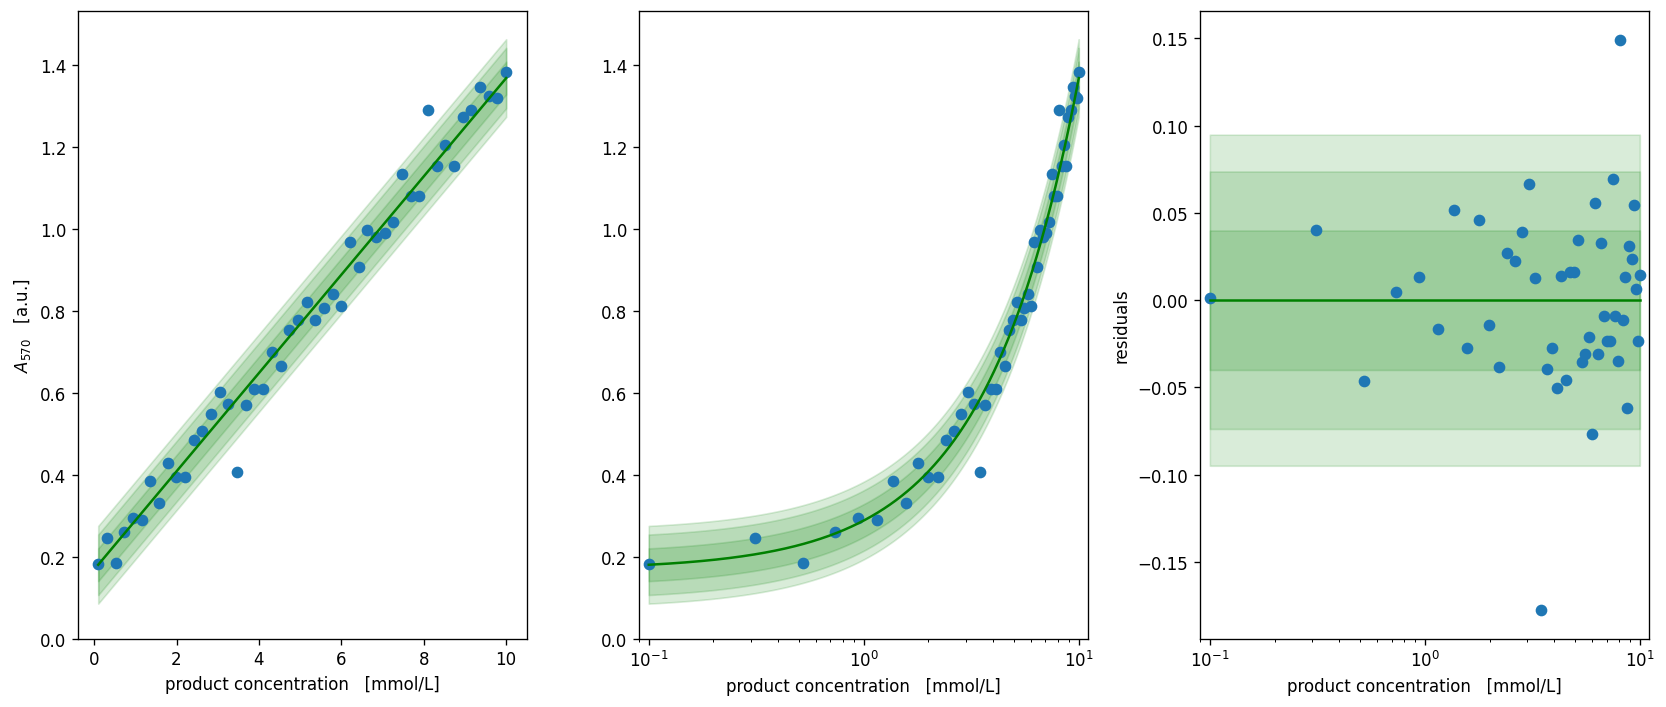

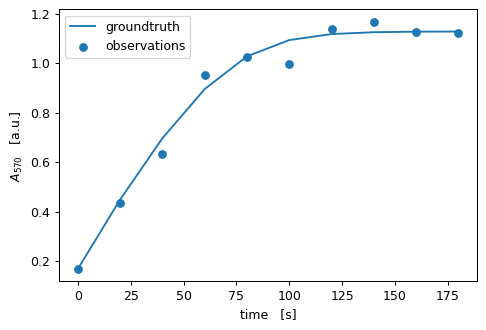

In [2]:
class ProductAssayModel(calibr8.BasePolynomialModelT):
    def __init__(self):
        super().__init__(
            independent_key='P',
            dependent_key='A570',
            mu_degree=1,
            scale_degree=0,
        )
        
def observe_with_true_parameters(x):
    return scipy.stats.t.rvs(loc=0.17 + 0.12 * x, scale=0.03, df=3)

# generate fake calibration data with a linear relationship
numpy.random.seed(202103)
N = 48
X = numpy.linspace(0.1, 10, N)
Y = observe_with_true_parameters(X)

cm_product = ProductAssayModel()
theta_fit, _ = calibr8.fit_scipy(
    cm_product,
    independent=X, dependent=Y,
    theta_guess=[0, 0.2, 0.05, 5],
    theta_bounds=[(-2, 2), (0.001, 0.5), (0.001, 0.5), (1, 10)]
)
fig, axs = calibr8.plot_model(cm_product);
for ax in axs:
    ax.set_xlabel('product concentration   [mmol/L]')
axs[0].set_ylabel('$A_{570}$   [a.u.]')
axs[1].set_ylabel("")
axs[0].set_ylim(bottom=0)
axs[1].set_ylim(bottom=0)
fig.tight_layout()
pyplot.show()

class MichaelisMentenModel(murefi.BaseODEModel):
    def __init__(self):
        self.guesses = dict(S_0=5, P_0=0, v_max=0.1, K_S=1)
        self.bounds = dict(
            S_0=(1, 20),
            P_0=(0, 10),
            v_max=(0.0001, 5),
            K_S=(0.01, 10),
        )
        super().__init__(
            independent_keys=['S', 'P'],
            parameter_names=["S_0", "P_0", "v_max", "K_S"],
        )

    def dydt(self, y, t, theta):
        S, P = y
        v_max, K_S = theta
        
        dPdt = v_max * S / (K_S + S)    
        return [
            -dPdt,
            dPdt,
        ]
    
model = MichaelisMentenModel()

# generate ground truth data at 10 time points
theta_true = (8, 0, 0.16, 2.5)
rep_groundtruth = model.predict_replicate(
    # S_0, P_0, v_max, K_S
    parameters=theta_true,
    template=murefi.Replicate.make_template(tmin=0, tmax=180, independent_keys='SP', rid='A01', N=10)
)

# use error model to make noisy observations of the ground truth
rep_observed = murefi.Replicate(rid='A01')
rep_observed['A570'] = murefi.Timeseries(
    t=rep_groundtruth['P'].t,
    y=observe_with_true_parameters(rep_groundtruth['P'].y),
    independent_key='P',
    dependent_key='A570'
)

# pack generated data into Dataset
dataset = murefi.Dataset()
dataset[rep_observed.rid] = rep_observed


fig, ax = pyplot.subplots(dpi=90)
ax.scatter(rep_observed['A570'].t, rep_observed['A570'].y, label='observations')
# use error model to project groundtruth onto dependent variable axis
ax.plot(rep_observed['A570'].t, cm_product.predict_dependent(rep_groundtruth["P"].y)[0], label='groundtruth')
ax.set(xlabel='time   [s]', ylabel='$A_{570}$   [a.u.]')
ax.legend()
pyplot.show()

## Objective function and gradients
Like introduced in the basic example we need a `ParameterMapping` to specify how we want to apply the model to the dataset.

In [3]:
df_mapping = pandas.DataFrame(columns='rid,S_0,P_0,v_max,K_S'.split(',')).set_index('rid')
# we'll fix S_0=8.0 and fit only the remaining parameters
df_mapping.loc['A01'] = (8.0, 'P_0', 'v_max', 'K_S')

# create the ParameterMapping object
pm = murefi.ParameterMapping(
    df_mapping,
    guesses=model.guesses,      # fed as dict where the key is the name of the parameter
    bounds=model.bounds         # same as guesses
)
display(pm.as_dataframe())
display(pm)

,S_0,P_0,v_max,K_S
rid,,,,
A01,8.0,P_0,v_max,K_S


ParameterMapping(1 replicates, 4 inputs, 3 free parameters)

The objective function is created in the same way:

In [4]:
obj = murefi.objectives.for_dataset(
    dataset,
    model,
    pm,
    # no need for a substrate calibration model, because there's no data
    calibration_models=[cm_product]
)

# The objective function can be evaluated at the initial guess to see if everything works as expected:
print(f'Negative log-likelihood at initial guess: {obj(pm.guesses)}')

Negative log-likelihood at initial guess: -11.265833923549405


With `theano` installed, the objective can be called with `TensorVariable`s to create a computation graph for the likelihood.

In [5]:
K_S = tt.scalar("K_S")
P_0 = tt.scalar("P_0")
v_max = tt.scalar("v_max")
theta = [K_S, P_0, v_max]

L = obj([K_S, P_0, v_max])
# If `sunode` is installed we can auto-differentiate:
L_grad = theano.grad(L, wrt=theta)

# We can compile function to evaluate L and L_grad:
f_L = theano.function(inputs=theta, outputs=[L])
f_L_grad = theano.function(inputs=theta, outputs=L_grad)

parameters = pm.guesses

In [6]:
print(f"""
Evaluations at pm.guesses:
obj      : {obj(parameters)}
f_L      :  {f_L(*parameters)[0]}
f_L_grad : {f_L_grad(*parameters)}
""")


Evaluations at pm.guesses:
obj      : -11.265833923549405
f_L      :  11.26583419825247
f_L_grad : [array(-6.79694195), array(16.53433171), array(442.18520326)]



In [7]:
# This cell needs graphviz and pydot:
# > conda install -c conda-forge python-graphviz
# > pip install pydot-ng

# Doesn't work because pydotprint is broken in Theano-PyMC 1.1.2
# This will only start working again with Aesara.
# theano.printing.pydotprint(f_L)

### Benchmarking
The compiled likelihood function with `sunode` should be faster than the `odeint`-based `obj`.
At the very least the autograd gradient should be faster than a manual one.

In [8]:
%%timeit
obj(parameters)

880 µs ± 3.13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%%timeit
f_L(*parameters)

1.22 ms ± 2.74 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%%timeit
f_L_grad(*parameters)

1.25 ms ± 4.71 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Building a Bayesian ODE model with `murefi`, `calibr8`, `sunode` and `pymc3`
So far we have just seen how an ODE model built with `murefi` and `calibr8` can be compiled with `theano` and auto-differentiated by `theano` and `sunode`.
The above steps are good to know about for those who want to leverage fast likelihoods and gradients for other methods, but for building a PyMC3 model all of this happens behind the scenes.

Here we just have to come up with priors for our model parameters and can just press the inference button™.

In [11]:
# first build the model
with pymc3.Model() as pmodel:
    t_theta = {
        'S_0': 8,
        'P_0': pymc3.Exponential('P_0', lam=4),
        'v_max': pymc3.Lognormal('v_max', mu=numpy.log(3/25), sd=1),
        'K_S': pymc3.Lognormal('K_S', mu=numpy.log(4), sd=1)
    }
    # Just pass the priors into the objective.
    # PyMC3, sunode, murefi and calibr8 take care of the rest.
    obj(t_theta)

# pymc3.model_to_graphviz(pmodel)

In [12]:
# then hit the inference button
with pmodel:
    idata = pymc3.sample(return_inferencedata=True, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [K_S, v_max, P_0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 58 seconds.


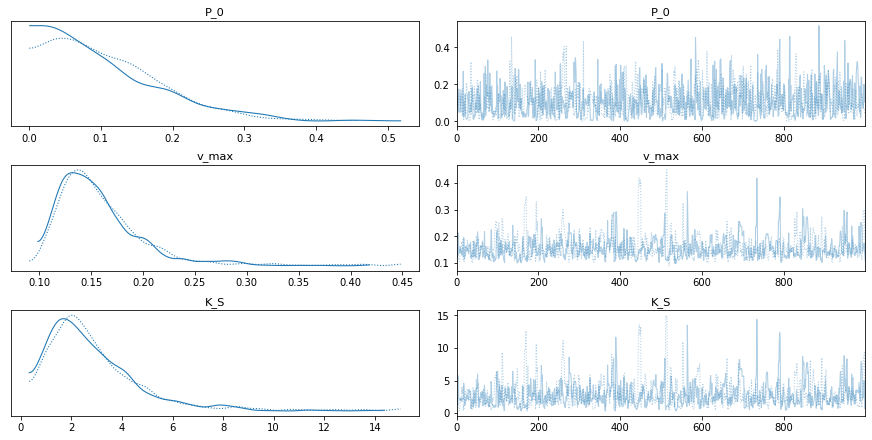

In [13]:
arviz.plot_trace(idata);

In [14]:
dataset_pred = model.predict_dataset(
    template=murefi.Dataset.make_template_like(dataset, independent_keys='SP'),
    parameter_mapping=pm,
    parameters={
        k : idata.posterior[k].stack(sample=('chain', 'draw')).values
        for k in pm.parameters.keys()
    }
)
dataset_pred

Dataset([('A01', Replicate(S[:200], P[:200]))])

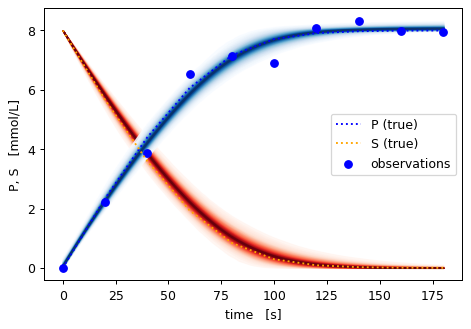

In [15]:
fig, ax = pyplot.subplots(dpi=90)
colors = dict(P='blue', S='orange')

pymc3.gp.util.plot_gp_dist(
    ax=ax,
    x=dataset_pred['A01']['S'].t,
    samples=dataset_pred['A01']['S'].y,
    palette='Reds',  plot_samples=False,
)
pymc3.gp.util.plot_gp_dist(
    ax=ax,
    x=dataset_pred['A01']['P'].t,
    samples=dataset_pred['A01']['P'].y,
    palette='Blues', plot_samples=False,
)

# plot data, transformed via the error model into the independent unit
x_obs = rep_observed['A570'].t
y_obs = cm_product.predict_independent(rep_observed['A570'].y)
ax.scatter(x_obs, y_obs, label='observations',color=colors['P'])
    
# plot all timeseries of the groundtruth for comparison
for ykey, ts in reversed(rep_groundtruth.items()):
    ax.plot(ts.t, ts.y, label=ykey + ' (true)', linestyle=':', color=colors[ykey])

ax.set_xlabel('time   [s]')
ax.set_ylabel('P, S   [mmol/L]')
ax.legend()
pyplot.show()

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Mar 22 2021

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

theano    : 1.1.2
murefi    : 4.2.2
numpy     : 1.20.1
pandas    : 1.2.3
arviz     : 0.11.2
calibr8   : 6.0.0
pymc3     : 3.11.2
matplotlib: 3.3.4
scipy     : 1.6.1
sunode    : 0.1.1

Watermark: 2.2.0

